# Coronagraph 430R vs 210R vs LWBAR

In [1]:
# If running Python 2.x, makes print and division act like Python 3
from __future__ import print_function, division

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Enable inline plotting at lower left
%matplotlib inline

from IPython.display import display, Latex, clear_output

We will start by first importing `pynrc` along with the `obs_hci` (High Contrast Imaging) class, which lives in the `pynrc.obs_nircam` module. 

In [2]:
import pynrc
from pynrc import nrc_utils          # Variety of useful functions and classes
from pynrc.obs_nircam import obs_hci # High-contrast imaging observation class

# Disable informational messages and only include warnings and higher
pynrc.setup_logging(level='WARN')

[     pynrc:INFO]   jwst_backgrounds is not installed and will not be used for bg estimates.
pyNRC log messages of level WARN and above will be shown.
pyNRC log outputs will be directed to the screen.


## Source Definitions

In the previous notebook, we simply used the `stellar_spectrum` functions to create sources normalized at their observed K-Band magnitude. This time, we will utilize the `source_spectrum` class to generate a model fit to the known spectrophotometry. The user can find the relevant photometric data at http://vizier.u-strasbg.fr/vizier/sed/ and click download data as a VOTable.

In [3]:
# Define 2MASS Ks bandpass and source information
bp_k = pynrc.bp_2mass('k')

# Science         source,  dist, age, sptype, Teff, [Fe/H], log_g, mag, band
args_sources = [('HR 8799', 39.0, 30,  'F0V', 7430, -0.47, 4.35, 5.24, bp_k)]

# References     source,     sptype, Teff, [Fe/H], log_g, mag, band
ref_sources = [('HD 220657', 'F8III', 5888, -0.01, 3.22, 3.04, bp_k)]

# Directory housing VOTables 
# http://vizier.u-strasbg.fr/vizier/sed/
votdir = 'GTO/votables/'

In [4]:
# Fit spectrum to SED photometry
i=0
name_sci, dist_sci, age, spt_sci, Teff_sci, feh_sci, logg_sci, mag_sci, bp_sci = args_sources[i]
vot = votdir + name_sci.replace(' ' ,'') + '.vot'

args = (name_sci, spt_sci, mag_sci, bp_sci, vot)
kwargs = {'Teff':Teff_sci, 'metallicity':feh_sci, 'log_g':logg_sci}
src = nrc_utils.source_spectrum(*args, **kwargs)

src.fit_SED(use_err=True, robust=True)

# Final source spectrum
sp_sci = src.sp_model

[0.98216073]


In [5]:
# Do the same for the reference source
name_ref, spt_ref, Teff_ref, feh_ref, logg_ref, mag_ref, bp_ref = ref_sources[i]
vot = votdir + name_ref.replace(' ' ,'') + '.vot'

args = (name_ref, spt_ref, mag_ref, bp_ref, vot)
kwargs = {'Teff':Teff_ref, 'metallicity':feh_ref, 'log_g':logg_ref}
ref = nrc_utils.source_spectrum(*args, **kwargs)

ref.fit_SED(use_err=False, robust=False, wlim=[0.5,5])

# Final reference spectrum
sp_ref = ref.sp_model

[1.07580856]


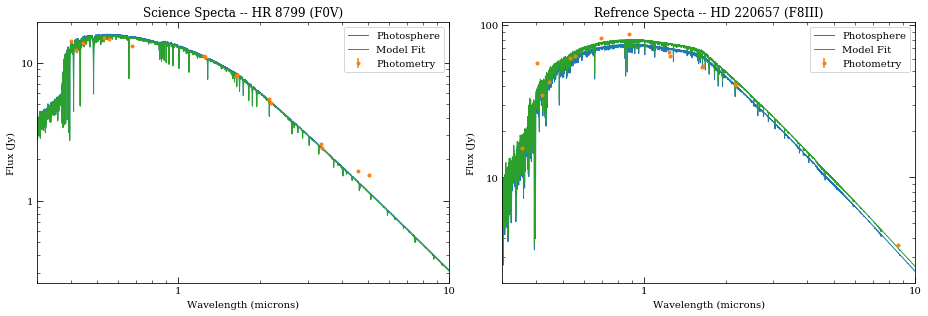

In [6]:
# Plot spectra 
fig, axes = plt.subplots(1,2, figsize=(13,4.5))
src.plot_SED(xr=[0.3,10], ax=axes[0])
ref.plot_SED(xr=[0.3,10], ax=axes[1])

axes[0].set_title('Science Specta -- {} ({})'.format(src.name, spt_sci))
axes[1].set_title('Refrence Specta -- {} ({})'.format(ref.name, spt_ref))

fig.tight_layout()

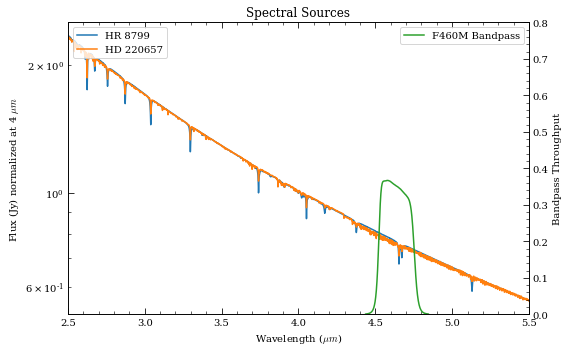

In [7]:
# Plot the two spectra
fig, ax = plt.subplots(1,1, figsize=(8,5))

xr = [2.5,5.5]

for sp in [sp_sci, sp_ref]:
    w = sp.wave / 1e4
    ind = (w>=xr[0]) & (w<=xr[1])
    sp.convert('Jy')
    f = sp.flux / np.interp(4.0, w, sp.flux)
    ax.semilogy(w[ind], f[ind], lw=1.5, label=sp.name)
    ax.set_ylabel('Flux (Jy) normalized at 4 $\mu m$')
    sp.convert('flam')

ax.set_xlim(xr)
ax.set_xlabel(r'Wavelength ($\mu m$)')
ax.set_title('Spectral Sources')

# Overplot Filter Bandpass
bp = pynrc.read_filter('F460M', 'WEDGELYOT', 'MASKLWB')
ax2 = ax.twinx()
ax2.plot(bp.wave/1e4, bp.throughput, color='C2', label=bp.name+' Bandpass')
ax2.set_ylim([0,0.8])
ax2.set_xlim(xr)
ax2.set_ylabel('Bandpass Throughput')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()

## Initialize Observation

Now we will initialize the high-contrast imaging class `pynrc.obs_hci` using the spectral objects and various other settings. The `obs_hci` object is a subclass of the more generalized `NIRCam` class. It implements new settings and functions specific to high-contrast imaging observations for corongraphy and direct imaging.

For this tutorial, we want to observe these targets using the `MASKLWB` coronagraph in the `F460M` filter. All wedge coronagraphic masks such as the `MASKLWB` (B=bar) should be paired with the `WEDGELYOT` pupil element. Observations in the LW channel are most commonly observed in `WINDOW` mode with a 320x320 detector subarray size. Full detector sizes are also available.

The wedge coronagraphs have an additional option to specify the location along the wedge to place your point source via the `bar_offset` keyword. If not specified, the location is automatically chosen based on the filter. A positive value will move the source to the right when viewing in V2/V3 coordiante convention (V2 to the left and V3 up). Specifying the location is a non-standard mode.

In this case, we're going to place our PSF at the narrow end of the LW bar, located `bar_offset=8` arcsec from the bar center.

In [19]:
filt, mask, pupil = ('F460M',  'MASK210R', 'CIRCLYOT')
wind_mode, subsize = ('WINDOW', 320)
fov_pix, oversample = (320, 2)

wfe_ref_drift = 0
obs = pynrc.obs_hci(sp_sci, sp_ref, dist_sci, filter=filt, mask=mask, pupil=pupil, 
                    wfe_ref_drift=wfe_ref_drift, fov_pix=fov_pix, oversample=oversample, 
                    wind_mode=wind_mode, xpix=subsize, ypix=subsize, verbose=True)

Generating background PSF coefficients...
Generating oversampled PSFs...
Updating NIRCam reference coefficients...
Creating NIRCam reference class...
Finished.


In [29]:
filt, mask, pupil = ('F460M',  'MASKLWB', 'WEDGELYOT')
wind_mode, subsize = ('WINDOW', 320)
fov_pix, oversample = (320, 2)

wfe_ref_drift = 0
obs = pynrc.obs_hci(sp_sci, sp_ref, dist_sci, filter=filt, mask=mask, pupil=pupil, 
                    wfe_ref_drift=wfe_ref_drift, fov_pix=fov_pix, oversample=oversample, 
                    wind_mode=wind_mode, xpix=subsize, ypix=subsize, verbose=True,
                    bar_offset=8)

[     pynrc:WARNING] Generating wedge field-dependent coefficients. This may take some time.


Generating background PSF coefficients...
Generating oversampled PSFs...
Updating NIRCam reference coefficients...
Creating NIRCam reference class...
Finished.


Just as a reminder, all information for the reference observation is stored in the attribute `obs.nrc_ref`, which is simply it's own isolated `NIRCam` class. The `bar_offset` value is initialized to be the same as the science observation. 

Now that we've succesffully initialized the obs_hci observations, let's specify the `wfe_ref_drift`. If this is your first time, then the `nrc_utils.wfed_coeff` function is called to determine a relationship between PSFs in the presense of WFE drift. This relationship is saved in the `PYNRC_DATA` directory as a set of polynomial coefficients. Future calculations utilize these coefficients to quickly generate a new PSF for any arbitary drift value.

In [30]:
# WFE drift amount between rolls
# This only gets called during gen_roll_image()
# and temporarily updates obs.wfe_drift to create
# a new PSF.
obs.wfe_roll_drift = 2

# Drift amount of reference relative to nominal.
# This is simply a link to obs.nrc_ref.wfe_drift
obs.wfe_ref_drift = 10

[     pynrc:WARNING] Generating WFE Drift coefficients. This may take some time.
[     pynrc:WARNING] Generating WFE Drift coefficients. This may take some time.


## Exposure Settings

Optimization of exposure settings are demonstrated in another tutorial, so we will not repeat that process here. We can assume that process was performed elsewhere to choose the `BRIGHT2` pattern with 10 groups and 40 total integrations. These settings apply to each roll position of the science observation as well as the for the reference observation.

In [31]:
# Update both the science and reference observations
# These numbers come from GTO Proposal 1194
obs.update_detectors(read_mode='BRIGHT2', ngroup=10, nint=40, verbose=True)
obs.nrc_ref.update_detectors(read_mode='BRIGHT2', ngroup=4, nint=90)

New Ramp Settings:
  read_mode :  BRIGHT2
  nf        :        2
  nd2       :        0
  ngroup    :       10
  nint      :       40
New Detector Settings
  wind_mode :   WINDOW
  xpix      :      320
  ypix      :      320
  x0        :      276
  y0        :     1523
New Ramp Times
  t_group   :    2.138
  t_frame   :    1.069
  t_int     :   21.381
  t_int_tot :   22.470
  t_exp     :  855.232
  t_acq     :  898.790


## Add Planets

There are four known giant planets orbiting HR 8799 at various locations. Ideally, we would like to position them at their predicted locations on the anticipated observation date. For this case, we choose a plausible observation date of November 1, 2019. To convert between $(x,y)$ and $(r,\theta)$, use the `nrc_utils.xy_to_rtheta` and `nrc_utils.rtheta_to_xy` functions.

When adding the planets, it doesn't matter too much which exoplanet model spectrum we decide to use since the spectra are still fairly unconstrained at these wavelengths. We do know roughly the planets' luminosities, so we can simply choose some reasonable model and renormalize it to the appropriate filter brightness. Currently, the only exoplanet spectral models available to `pynrc` are those from Spiegel & Burrows (2012).



In [32]:
# Projected locations for date 11/01/2019
# These are prelimary positions, but within constrained orbital parameters
loc_list = [(-1.57, 0.64), (0.42, 0.87), (0.5, -0.45), (0.35,  0.20)]

# Estimated magnitudes within F460M filter
pmags = [16.0, 15.0, 14.6, 14.7]

In [33]:
# Add planet information to observation class.
# These are stored in obs.planets.
# Can be cleared using obs.kill_planets().
obs.kill_planets()
for i, loc in enumerate(loc_list):
    obs.add_planet(mass=10, entropy=13, age=age, xy=loc, runits='arcsec', 
                   renorm_args=(pmags[i], 'vegamag', obs.bandpass))

In [34]:
# Generate and plot a noiseless slope image to make sure things look right
PA1 = 85
im_planets = obs.gen_planets_image(PA_offset=PA1)

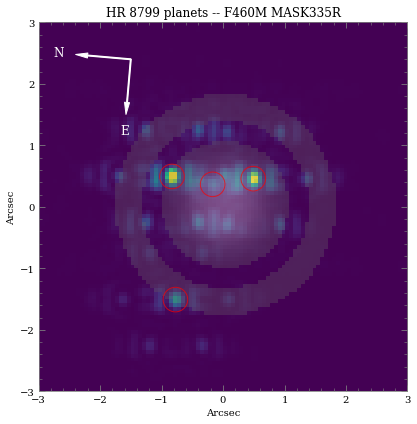

In [14]:
from matplotlib.patches import Circle
from pynrc.nrc_utils import (coron_ap_locs, build_mask_detid, fshift, pad_or_cut_to_size)

fig, ax = plt.subplots(figsize=(6,6))

xasec = obs.det_info['xpix'] * obs.pix_scale
yasec = obs.det_info['ypix'] * obs.pix_scale
extent = [-xasec/2, xasec/2, -yasec/2, yasec/2]
xylim = 3

vmin = 0
vmax = 0.75*im_planets.max()
ax.imshow(im_planets, extent=extent, vmin=vmin, vmax=vmax)

# Overlay the coronagraphic mask
detid = obs.Detectors[0].detid
im_mask = obs.mask_images[detid]
# Do some masked transparency overlays
masked = np.ma.masked_where(im_mask>0.99, im_mask)
#ax.imshow(1-masked, extent=extent, alpha=0.5)
ax.imshow(1-masked, extent=extent, alpha=0.3, cmap='Greys_r', vmin=-0.5)

xc_off = obs.bar_offset
for loc in loc_list:
    xc, yc = loc
    xc, yc = nrc_utils.xy_rot(xc, yc, PA1)
    xc += xc_off
    circle = Circle((xc,yc), radius=xylim/15., alpha=0.7, lw=1, edgecolor='red', facecolor='none')
    ax.add_artist(circle)

xlim = ylim = np.array([-1,1])*xylim
xlim = xlim + xc_off
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel('Arcsec')
ax.set_ylabel('Arcsec')

ax.set_title('{} planets -- {} {}'.format(sp_sci.name, obs.filter, obs.mask))

color = 'grey'
ax.tick_params(axis='both', color=color, which='both')
for k in ax.spines.keys():
    ax.spines[k].set_color(color)

nrc_utils.plotAxes(ax, width=1, headwidth=5, alength=0.15, angle=PA1, 
                   position=(0.25,0.9), label1='E', label2='N')

fig.tight_layout()

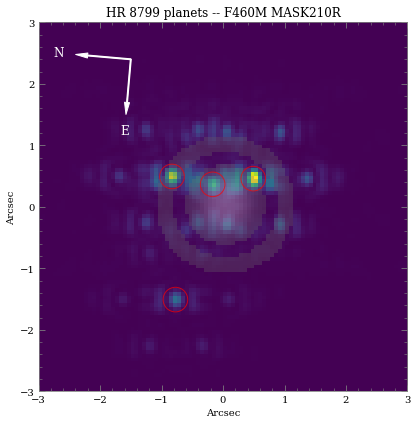

In [25]:
from matplotlib.patches import Circle
from pynrc.nrc_utils import (coron_ap_locs, build_mask_detid, fshift, pad_or_cut_to_size)

fig, ax = plt.subplots(figsize=(6,6))

xasec = obs.det_info['xpix'] * obs.pix_scale
yasec = obs.det_info['ypix'] * obs.pix_scale
extent = [-xasec/2, xasec/2, -yasec/2, yasec/2]
xylim = 3

vmin = 0
vmax = 0.75*im_planets.max()
ax.imshow(im_planets, extent=extent, vmin=vmin, vmax=vmax)

# Overlay the coronagraphic mask
detid = obs.Detectors[0].detid
im_mask = obs.mask_images[detid]
# Do some masked transparency overlays
masked = np.ma.masked_where(im_mask>0.99, im_mask)
#ax.imshow(1-masked, extent=extent, alpha=0.5)
ax.imshow(1-masked, extent=extent, alpha=0.3, cmap='Greys_r', vmin=-0.5)

xc_off = obs.bar_offset
for loc in loc_list:
    xc, yc = loc
    xc, yc = nrc_utils.xy_rot(xc, yc, PA1)
    xc += xc_off
    circle = Circle((xc,yc), radius=xylim/15., alpha=0.7, lw=1, edgecolor='red', facecolor='none')
    ax.add_artist(circle)

xlim = ylim = np.array([-1,1])*xylim
xlim = xlim + xc_off
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel('Arcsec')
ax.set_ylabel('Arcsec')

ax.set_title('{} planets -- {} {}'.format(sp_sci.name, obs.filter, obs.mask))

color = 'grey'
ax.tick_params(axis='both', color=color, which='both')
for k in ax.spines.keys():
    ax.spines[k].set_color(color)

nrc_utils.plotAxes(ax, width=1, headwidth=5, alength=0.15, angle=PA1, 
                   position=(0.25,0.9), label1='E', label2='N')

fig.tight_layout()

As we can see, even with "perfect PSF subtraction" and no noise, it's difficult to make out planet e. This is primarily due to its location relative to the occulting mask reducing throughput combined with confusion of bright diffraction spots from nearby sources.

## Estimated Performance

Now we are ready to determine contrast performance and sensitivites as a function of distance from the star. 

### Roll-Subtracted Images

First, we will create a quick simulated roll-subtracted image using the in `gen_roll_image` method. For the selected observation date of 11/1/2019, APT shows a PA range of 84$^{\circ}$ to 96$^{\circ}$. So, we'll assume Roll 1 has PA1=85, while Roll 2 has PA2=95. In this case, "roll subtraction" simply creates two science observations at two different parallactic angles and subtracts the same reference observation from each. The two results are then de-rotated to a common PA=0 and averaged.

There is also the option to create ADI images, where the other roll position becomes the reference star by setting `no_ref=True`. 

### Contrast Curves

Next, we will cycle through a few WFE drift values to get an idea of potential predicted sensitivity curves. The `calc_contrast` method returns a tuple of three arrays:
1. The radius in arcsec.
2. The n-sigma contrast.
3. The n-sigma magnitude sensitivity limit (vega mag).

In [35]:
# Cycle through a few WFE drift values
wfe_list = [0,5,10]
nsig = 5

# PA values for each roll
PA1, PA2 = (85, 95)
roll_angle = np.abs(PA2 - PA1)

# A dictionary of HDULists
hdul_dict = {}
hdul_dict2 = {}
curves = []
for i, wfe_drift in enumerate(wfe_list):
    print(wfe_drift)
    # Upate WFE reference drift value
    obs.wfe_ref_drift = wfe_drift
            
    # Set the final output image to be oversampled
    hdulist = obs.gen_roll_image(PA1=PA1, PA2=PA2)
    hdul_dict[wfe_drift] = hdulist
    
    # Generate contrast curves
    result = obs.calc_contrast(roll_angle=roll_angle, nsig=nsig)
    curves.append(result)


0
5
10


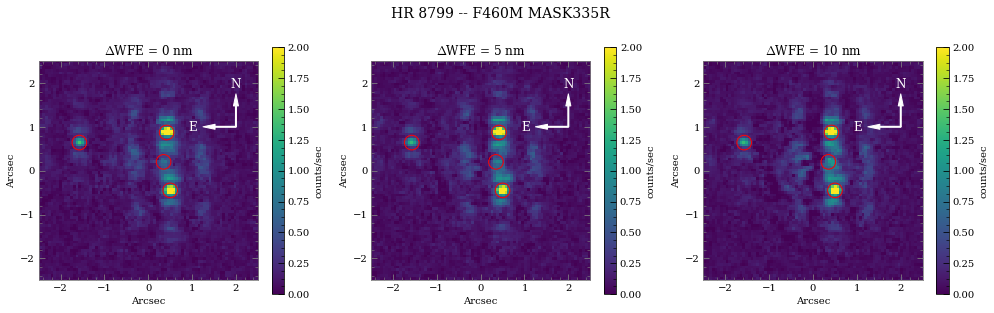

In [17]:
from pynrc.obs_nircam import plot_hdulist
from matplotlib.patches import Circle

fig, axes = plt.subplots(1,3, figsize=(14,4.3))
xylim = 2.5
xlim = ylim = np.array([-1,1])*xylim

for j, wfe_drift in enumerate(wfe_list):
    ax = axes[j]
    hdul = hdul_dict[wfe_drift]
    
    plot_hdulist(hdul, xr=xlim, yr=ylim, ax=ax, vmin=0, vmax=2, axes_color='grey')

    # Location of planet
    for loc in loc_list:
        circle = Circle(loc, radius=xylim/15., lw=1, edgecolor='red', facecolor='none')
        ax.add_artist(circle)

    ax.set_title('$\Delta$WFE = {:.0f} nm'.format(wfe_drift))
    
    nrc_utils.plotAxes(ax, width=1, headwidth=5, alength=0.15, position=(0.9,0.7), label1='E', label2='N')

fig.suptitle('{} -- {} {}'.format(name_sci, obs.filter, obs.mask), fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.85)

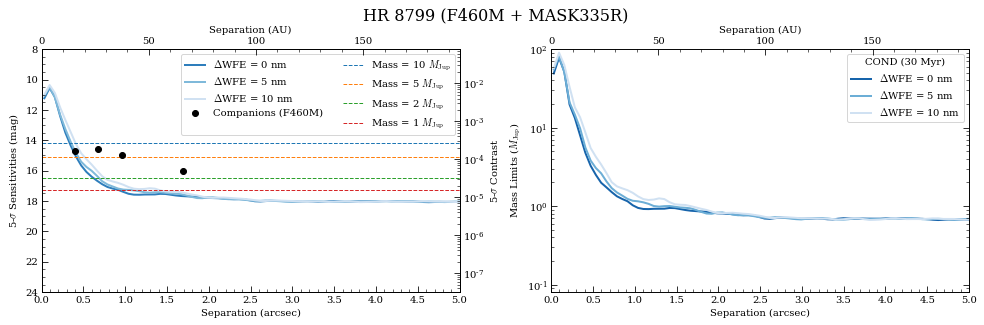

In [18]:
from pynrc.obs_nircam import plot_contrasts, plot_planet_patches, plot_contrasts_mjup
import matplotlib.patches as mpatches

# fig, ax = plt.subplots(figsize=(8,5))
fig, axes = plt.subplots(1,2, figsize=(14,4.5))
xr=[0,5]
yr=[24,8]

# 1a. Plot contrast curves and set x/y limits
ax = axes[0]
ax, ax2, ax3 = plot_contrasts(curves, nsig, wfe_list, obs=obs, 
                              xr=xr, yr=yr, ax=ax, return_axes=True)
# 1b. Plot the locations of exoplanet companions
label = 'Companions ({})'.format(filt)
planet_dist = [np.sqrt(x**2+y**2) for x,y in loc_list]
ax.plot(planet_dist, pmags, marker='o', ls='None', label=label, color='k', zorder=10)    

# 1c. Plot Spiegel & Burrows (2012) exoplanet fluxes (Hot Start)
plot_planet_patches(ax, obs, age=age, entropy=13, av_vals=None)
ax.legend(ncol=2)

# 2. Plot in terms of MJup using COND models
ax = axes[1]
plot_contrasts_mjup(curves, nsig, wfe_list, obs=obs, age=age,
                    ax=ax, twin_ax=True, xr=xr, yr=None)
ax.set_yscale('log')
ax.set_ylim([0.08,100])
ax.legend(loc='upper right', title='COND ({:.0f} Myr)'.format(age))

fig.suptitle('{} ({} + {})'.format(name_sci, obs.filter, obs.mask), fontsize=16)

fig.tight_layout()
fig.subplots_adjust(top=0.85, bottom=0.1 , left=0.05, right=0.97)

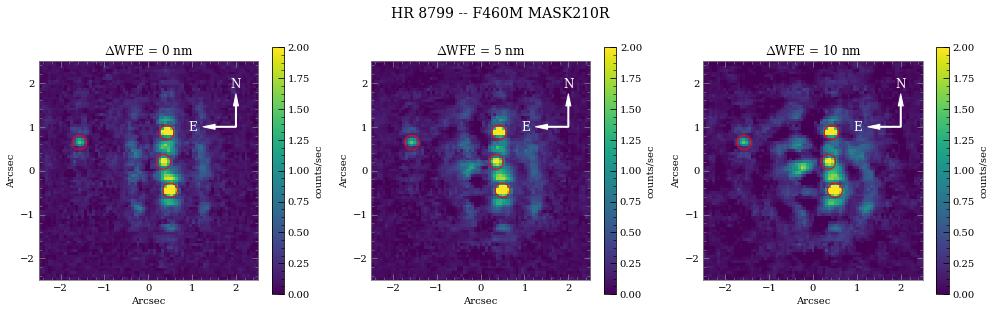

In [27]:
from pynrc.obs_nircam import plot_hdulist
from matplotlib.patches import Circle

fig, axes = plt.subplots(1,3, figsize=(14,4.3))
xylim = 2.5
xlim = ylim = np.array([-1,1])*xylim

for j, wfe_drift in enumerate(wfe_list):
    ax = axes[j]
    hdul = hdul_dict[wfe_drift]
    
    plot_hdulist(hdul, xr=xlim, yr=ylim, ax=ax, vmin=0, vmax=2, axes_color='grey')

    # Location of planet
    for loc in loc_list:
        circle = Circle(loc, radius=xylim/15., lw=1, edgecolor='red', facecolor='none')
        ax.add_artist(circle)

    ax.set_title('$\Delta$WFE = {:.0f} nm'.format(wfe_drift))
    
    nrc_utils.plotAxes(ax, width=1, headwidth=5, alength=0.15, position=(0.9,0.7), label1='E', label2='N')

fig.suptitle('{} -- {} {}'.format(name_sci, obs.filter, obs.mask), fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.85)

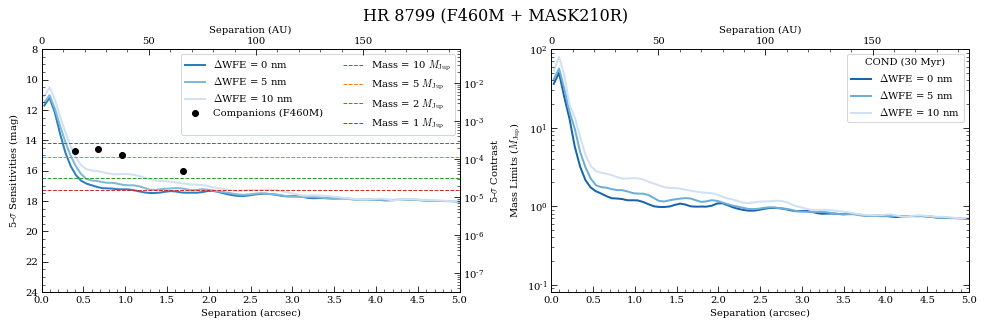

In [28]:
from pynrc.obs_nircam import plot_contrasts, plot_planet_patches, plot_contrasts_mjup
import matplotlib.patches as mpatches

# fig, ax = plt.subplots(figsize=(8,5))
fig, axes = plt.subplots(1,2, figsize=(14,4.5))
xr=[0,5]
yr=[24,8]

# 1a. Plot contrast curves and set x/y limits
ax = axes[0]
ax, ax2, ax3 = plot_contrasts(curves, nsig, wfe_list, obs=obs, 
                              xr=xr, yr=yr, ax=ax, return_axes=True)
# 1b. Plot the locations of exoplanet companions
label = 'Companions ({})'.format(filt)
planet_dist = [np.sqrt(x**2+y**2) for x,y in loc_list]
ax.plot(planet_dist, pmags, marker='o', ls='None', label=label, color='k', zorder=10)    

# 1c. Plot Spiegel & Burrows (2012) exoplanet fluxes (Hot Start)
plot_planet_patches(ax, obs, age=age, entropy=13, av_vals=None)
ax.legend(ncol=2)

# 2. Plot in terms of MJup using COND models
ax = axes[1]
plot_contrasts_mjup(curves, nsig, wfe_list, obs=obs, age=age,
                    ax=ax, twin_ax=True, xr=xr, yr=None)
ax.set_yscale('log')
ax.set_ylim([0.08,100])
ax.legend(loc='upper right', title='COND ({:.0f} Myr)'.format(age))

fig.suptitle('{} ({} + {})'.format(name_sci, obs.filter, obs.mask), fontsize=16)

fig.tight_layout()
fig.subplots_adjust(top=0.85, bottom=0.1 , left=0.05, right=0.97)

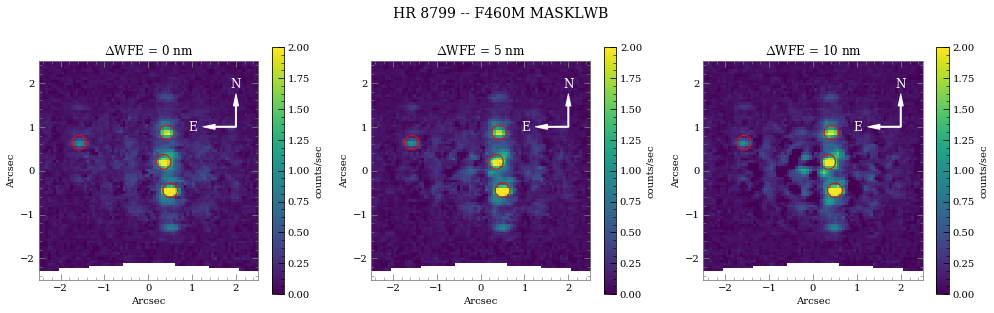

In [36]:
from pynrc.obs_nircam import plot_hdulist
from matplotlib.patches import Circle

fig, axes = plt.subplots(1,3, figsize=(14,4.3))
xylim = 2.5
xlim = ylim = np.array([-1,1])*xylim

for j, wfe_drift in enumerate(wfe_list):
    ax = axes[j]
    hdul = hdul_dict[wfe_drift]
    
    plot_hdulist(hdul, xr=xlim, yr=ylim, ax=ax, vmin=0, vmax=2, axes_color='grey')

    # Location of planet
    for loc in loc_list:
        circle = Circle(loc, radius=xylim/15., lw=1, edgecolor='red', facecolor='none')
        ax.add_artist(circle)

    ax.set_title('$\Delta$WFE = {:.0f} nm'.format(wfe_drift))
    
    nrc_utils.plotAxes(ax, width=1, headwidth=5, alength=0.15, position=(0.9,0.7), label1='E', label2='N')

fig.suptitle('{} -- {} {}'.format(name_sci, obs.filter, obs.mask), fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.85)

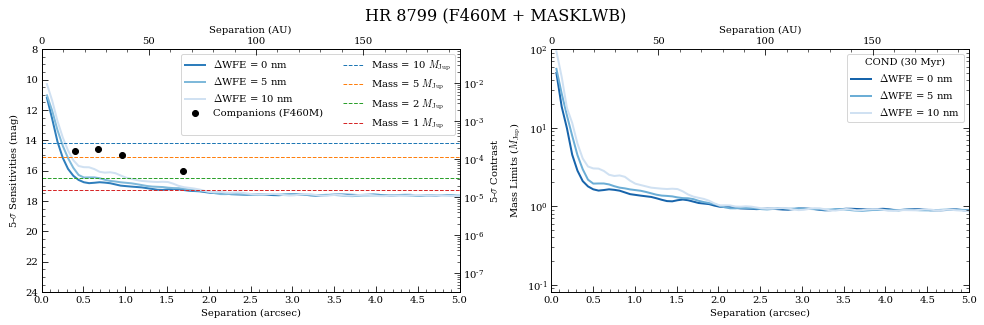

In [37]:
from pynrc.obs_nircam import plot_contrasts, plot_planet_patches, plot_contrasts_mjup
import matplotlib.patches as mpatches

# fig, ax = plt.subplots(figsize=(8,5))
fig, axes = plt.subplots(1,2, figsize=(14,4.5))
xr=[0,5]
yr=[24,8]

# 1a. Plot contrast curves and set x/y limits
ax = axes[0]
ax, ax2, ax3 = plot_contrasts(curves, nsig, wfe_list, obs=obs, 
                              xr=xr, yr=yr, ax=ax, return_axes=True)
# 1b. Plot the locations of exoplanet companions
label = 'Companions ({})'.format(filt)
planet_dist = [np.sqrt(x**2+y**2) for x,y in loc_list]
ax.plot(planet_dist, pmags, marker='o', ls='None', label=label, color='k', zorder=10)    

# 1c. Plot Spiegel & Burrows (2012) exoplanet fluxes (Hot Start)
plot_planet_patches(ax, obs, age=age, entropy=13, av_vals=None)
ax.legend(ncol=2)

# 2. Plot in terms of MJup using COND models
ax = axes[1]
plot_contrasts_mjup(curves, nsig, wfe_list, obs=obs, age=age,
                    ax=ax, twin_ax=True, xr=xr, yr=None)
ax.set_yscale('log')
ax.set_ylim([0.08,100])
ax.legend(loc='upper right', title='COND ({:.0f} Myr)'.format(age))

fig.suptitle('{} ({} + {})'.format(name_sci, obs.filter, obs.mask), fontsize=16)

fig.tight_layout()
fig.subplots_adjust(top=0.85, bottom=0.1 , left=0.05, right=0.97)